# Flower401
In this project, our approach is to combine a pretrained image classfier like ResNet with a specialized encoder that is trained inside an autoencoder network on additional larger flower image dataset (Flowers299 - https://www.kaggle.com/datasets/bogdancretu/flower299/data) . In addition, we use CBAM to generate attention maps and multiply to each of the outputs of the pretrained image classifier and our encoder network which would determine most important features across both spatial and channel spaces. We then flatten the result and use them as inputs for our classifier block which would be trained using the Flowers102 dataset.

In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torchvision.datasets as datasets
import torch
from torch import nn
import ml_collections
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import numpy as np
import copy

# Use cuda for running
dtype = torch.cuda.FloatTensor

### Setup

In [ ]:
# Install required modules
!pip install ml_collections
!pip install numba

Download Flowers-299 dataset from https://www.kaggle.com/datasets/bogdancretu/flower299/data as zip within the project folder and replace the path below with zip file's path

In [ ]:
!unzip /content/drive/MyDrive/Flower299/archive.zip -d Flowers299

## 1. Encoder and Trainer Autoencoder Implementations

In [2]:
# List of available pretrained resnets from pytorch
class Pretrains():
    resnet_versions = [
        'resnet18',
        'resnet34',
        'resnet50',
        'resnet101',
        'resnet152'
    ]
    vgg_versions = [
        'vgg11',
        'vgg11_bn',
        'vgg13',
        'vgg13_bn',
        'vgg16',
        'vgg16_bn',
        'vgg19',
        'vgg19_bn'
    ]

# Wrapper class for getting torch activation function from config
class ActivationFunction(nn.Module):
    def __init__(self, config):
        super(ActivationFunction, self).__init__()
        # Select torch's activation functions based on config
        match config.type:
            case 'LeakyReLU':
                self.activation_func = nn.LeakyReLU(
                    config.negative_slope,
                    inplace = True
                )
            case 'ReLU':
                self.activation_func = nn.ReLU(inplace = True)
            case 'Softmax':
                self.activation_func = nn.Softmax(dim = self.dim)
            case _:
                raise ValueError('Invalid activation function or not implemented')
    def forward(self, x):
        return self.activation_func(x)

# Base block with multiple layers of 2d convolution, batchnorm and activation function
class Conv2dBlock(nn.Module):
    def __init__(self, config):
        super(Conv2dBlock, self).__init__()
        modules = []
        if config.layer_num < 1:
            raise ValueError('Number of layers cannot be less than 1')
        for layer_idx in range(config.layer_num):
            # Conv2d
            modules.append(nn.Conv2d(
                config.in_channels if not layer_idx else config.out_channels,
                config.out_channels,
                kernel_size = 3,
                padding = 1
            ))

            # Batch Normalization
            if config.use_batchnorm:
                modules.append(nn.BatchNorm2d(config.out_channels))

            # Activation function, skip this step if skip_last_activation is True
            if config.skip_last_activation and layer_idx == config.layer_num - 1:
                break
            modules.append(ActivationFunction(config.activation_func))
        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)

# Creates a mirrored Conv2dBlock for decoder
class RevConv2dBlock(nn.Module):
    def __init__(self, conv2d_block):
        super(RevConv2dBlock, self).__init__()

        # Reverses module from conv2d_block
        modules = list(conv2d_block.sequential)
        modules.reverse()
        module_iterator = iter(range(len(modules)))
        for idx in module_iterator:
            if isinstance(modules[idx], torch.nn.modules.batchnorm.BatchNorm2d):

                # Switch order of batch and conv2d
                modules[idx], modules[idx + 1] = modules[idx + 1], modules[idx]

                # Swap conv2d with convtranspose2d
                modules[idx] = nn.ConvTranspose2d(
                    modules[idx].out_channels,
                    modules[idx].in_channels,
                    kernel_size = modules[idx].kernel_size,
                    stride = modules[idx].stride,
                    padding = modules[idx].padding
                )

                modules[idx + 1] = nn.BatchNorm2d(modules[idx].out_channels)

                # Skip next index
                next(module_iterator)

        if isinstance(modules[0], ActivationFunction):
            activation_func = modules.pop(0)
            modules.append(activation_func)

        self.sequential = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequential(x)

# VGG base block implementation
class VGGBackboneBlock(nn.Module):
    def __init__(self, config):
        super(VGGBackboneBlock, self).__init__()
        config.skip_last_activation = False

        # Conv2d
        self.conv2d_block = Conv2dBlock(config)

        # Maxpool
        self.maxpool = nn.MaxPool2d(
            kernel_size=config.compression_ratio,
            stride=config.compression_ratio
        )

    def forward(self, x):
        out = self.conv2d_block(x)
        out = self.maxpool(out)
        return out

    def get_reverse(self):
        return RevVGGBackconeBlock(self)

# Creates a mirrored VGGBackboneBlock for decoder, not used
class RevVGGBackconeBlock(nn.Module):
    def __init__(self, vgg_backbone_block):
        super(VGGBackboneBlock).__init__()
        # To be implemented
    def forward(self, x):
        # To be implemented
        return x

# Composed of shortcut and main path with different block depths.
class ResidualBlock(nn.Module):
    def __init__(self, config):
        super(ResidualBlock, self).__init__()

        # Main Conv2d block
        main_block_config = config
        main_block_config.layer_num = config.main_layer_num
        main_block_config.skip_last_activation = True
        self.main_block = Conv2dBlock(main_block_config)

        # Shortcut Conv2d block, we leave self.shortcut_block as undefined if shortcut layer depth = 0
        if config.shortcut_layer_num:
            shortcut_block_config = config
            shortcut_block_config.layer_num = config.shortcut_layer_num
            shortcut_block_config.skip_last_activation = True
            self.shortcut_block = Conv2dBlock(shortcut_block_config)

        self.activation_func = ActivationFunction(config.activation_func)

        # Optional maxpooling layer if compression_ratio is set
        if hasattr(config, 'compression_ratio'):
            self.maxpool = nn.MaxPool2d(
                kernel_size=config.compression_ratio,
                stride=config.compression_ratio
        )

    def forward(self, x):
        out = self.main_block(x)
        if hasattr(self, 'shortcut_block'):
            out += self.shortcut_block(x)
        else:
            out += x

        out = self.activation_func(out)

        if hasattr(self, 'maxpool'):
            out = self.maxpool(out)

        return out

    def get_reverse(self):
        # Get reversed version
        return RevResidualBlock(self)

# Creates a mirrored ResidualBlock for decoder
class RevResidualBlock(nn.Module):
    def __init__(self, residual_block):
        super(RevResidualBlock, self).__init__()
        # Create mirrored of components in template residual block
        self.main_block = RevConv2dBlock(residual_block.main_block)

        if hasattr(residual_block, 'shortcut_block'):
            self.shortcut_block = RevConv2dBlock(residual_block.shortcut_block)

        if hasattr(residual_block, 'maxpool'):
            self.upsample = nn.Upsample(scale_factor=residual_block.maxpool.stride)

        self.activation_func = copy.deepcopy(residual_block.activation_func)

    def forward(self, x):
        if hasattr(self, 'upsample'):
            x = self.upsample(x)
        else:
            x = x

        out = self.main_block(x)

        if hasattr(self, 'shortcut_block'):
            out += self.shortcut_block(x)
        else:
            out += x

        out = self.activation_func(out)
        return out

# Encoder module, currently implemented only for residual block submodules
class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        modules = []
        match config.type:
            case 'residual_blocks':
                for idx, block_feature in enumerate(config.features):
                    if not idx:
                        in_channels = config.in_channels
                        out_channels = block_feature
                    else:
                        in_channels = config.features[idx - 1]
                        out_channels = block_feature

                    block_config = ml_collections.ConfigDict({
                        'main_layer_num': config.main_layer_num,
                        'shortcut_layer_num': config.shortcut_layer_num,
                        'in_channels': in_channels,
                        'out_channels': out_channels,
                        'use_batchnorm': config.use_batchnorm,
                        'activation_func': config.activation_func,
                    })
                    if hasattr(config, 'compression_ratio'):
                        block_config.compression_ratio = config.compression_ratio

                    modules.append(ResidualBlock(block_config))
            case 'vgg_backbone_blocks':
                # To be implemented
                raise NotImplementedError('To be implemented')

        self.sequential = nn.Sequential(*modules)
    def forward(self, x):
        return self.sequential(x)

# Decoder module
class Decoder(nn.Module):
    def __init__(self, arg):
        super(Decoder, self).__init__()
        # Initialize by mirroring encoder
        if isinstance(arg, Encoder):
            encoder = arg
            modules = list(encoder.sequential)
            modules.reverse()

            for idx in range(len(modules)):
                modules[idx] = modules[idx].get_reverse()
            self.sequential = nn.Sequential(*modules)
        # Initialize by config (not implemented since we are using mirrored encoder/decoder)
        else:
            raise NotImplementedError('This decoder class is only implemented to be initialized by mirroring an encoder class')
    def forward(self, x):
        return self.sequential(x)

# Autoencoder class that is used to train encoder for main network. Configurable by config object to support hyyperparameter tuning
class AutoEncoder(nn.Module):
    def __init__(self, config):
        super(AutoEncoder, self).__init__()
        # Encodelocal
        local_config = copy.deepcopy(config)
        encoder_config = local_config.encoder_config
        encoder_config.in_channels = local_config.in_channels
        self.encoder = Encoder(encoder_config)

        # Check for bottleneck input size by passing dummy input to encoder
        dummy_input = torch.randn(1, local_config.in_channels, local_config.in_dimension[0], local_config.in_dimension[1])
        out = self.encoder.forward(dummy_input)
        out_dimension = list(out.size())
        in_bottleneck = out_dimension[1] * out_dimension[2] * out_dimension[3]

        # Bottleneck
        self.bottleneck = nn.Linear(in_bottleneck, local_config.bottleneck_width)

        # Bottleneck output reshaper
        self.decoder_in_shape = out_dimension
        self.bottleneck_reshape = nn.Conv2d(local_config.bottleneck_width, out_dimension[1], kernel_size=1)

        # Decoder
        self.decoder = Decoder(self.encoder)

    def forward(self, x):
        # Encoder
        out = self.encoder(x)

        # Reshape to fit bottleneck
        encoder_out_shape = out.size()
        flatten = out.view(out.size(0), -1)

        # Bottleneck
        out = self.bottleneck(flatten)

        # Reshape to fit decoder
        out_reshaped = out.view(out.size()[0], out.size()[1], 1, 1)
        out = self.bottleneck_reshape(out_reshaped)
        out = nn.AdaptiveAvgPool2d((self.decoder_in_shape[2], self.decoder_in_shape[3]))(out)

        # Decoder
        out = self.decoder(out)

        return out

### Parameters

In [3]:
# AutoEncoder input and output resolution, size = (dimension, dimension)
dimension = 128

In [4]:
# Example config dict for creating an autoencoder model
config_dict = {
    'in_dimension': (dimension, dimension),
    'in_channels': 3,
    'encoder_config': {
        'type': 'residual_blocks',
        'compression_ratio': 2,
        'features': [64, 128, 256, 512, 512, 512],
        'main_layer_num': 3,
        'shortcut_layer_num': 1,
        'use_batchnorm': True,
        'activation_func': {
            'type': 'LeakyReLU',
            'negative_slope': 0.1
        },
    },
    'decoder_config': {
        'mirror_encoder': True
    },
    'bottleneck_width': 256
}


test_config = ml_collections.ConfigDict(config_dict)

autoencoder = AutoEncoder(test_config).cuda()
autoencoder.forward(torch.randn(1, 3, 128, 128).type(dtype)).size()

torch.Size([1, 3, 128, 128])

## 2. Encoder Hyperparameter Tuning

In [5]:
# All hyperparameters to be tuned for the autoencoder network
configs_dict = {
    'in_dimension': [(dimension, dimension)],
    'in_channels': [3],
    'encoder_config': {
        'type': ['residual_blocks'],
        'compression_ratio': [2],
        'features': [
            [64, 128, 256, 512, 512, 512],
            [64, 128, 256, 512, 512],
            [64, 128, 256],
            [32, 64, 128, 256, 512, 512, 512],
            [32, 64, 128, 256, 512, 512],
            [32, 64, 128, 256, 512],
            [16, 32, 64, 128, 256, 512, 512],
            [16, 32, 64, 128, 256, 512],
            [16, 32, 64, 128, 256],
        ],
        'main_layer_num': [3, 2],
        'shortcut_layer_num': [1],
        'use_batchnorm': [True],
        'activation_func':[
            {
                'type': 'LeakyReLU',
                'negative_slope': 0.1
            },
            {
                'type': 'LeakyReLU',
                'negative_slope': 0.2
            },
            {
                'type': 'ReLU',
            }
        ]

    },
    'decoder_config': {
        'mirror_encoder': [True]
    },
    'bottleneck_width': [256, 512, 1024, 2048]
}
configs = ml_collections.ConfigDict(configs_dict)

# Parse ConfigDict with hyperparameters to be tuned and output list of all ConfigDicts to be tested
def generate_configs(configs):
    config_list = [ml_collections.ConfigDict()]
    for key in configs:
        new_config_list = []

        current_key_configs = []
        if isinstance(configs[key], list):
            current_key_configs = configs[key]
        elif isinstance(configs[key], ml_collections.config_dict.config_dict.ConfigDict):
            current_key_configs = generate_configs(configs[key])
        else:
            raise TypeError(configs[key] + ' is neither a list nor an ml_collections.ConfigDict object')
            
        for key_config in current_key_configs:
            for prev_config in config_list:
                prev_config_copy = copy.deepcopy(prev_config)
                prev_config_copy[key] = key_config
                new_config_list.append(prev_config_copy)
        config_list = new_config_list
    return config_list

config_list = generate_configs(configs)

### Test Optimal Batch Size for Running
Check the time taken for each batch size for optimizing hyperparameter tuning runtime

In [ ]:
import time
import gc
from numba import cuda

num_batch = 128
batch_sizes = [4, 8, 16, 32, 64]
time_taken = []

# Loop over different batch sizes and record time taken to run
for batch_size in tqdm(batch_sizes):
    # Clear Cache
    torch.cuda.empty_cache()
    gc.collect()
    autoencoder = AutoEncoder(test_config).cuda()
    start_time = time.time()
    
    # Test model with random data
    for batch in range(int(num_batch/batch_size)):
        autoencoder.forward(torch.randn(batch_size, 3, dimension, dimension).type(dtype))
    time_taken.append((batch_size, time.time() - start_time))

In [ ]:
# Print time taken to run each batch size
for data_point in time_taken:
    print(f'Batch Size {data_point[0]}: {data_point[1]}')

In [ ]:
# Clear Cache
torch.cuda.empty_cache()
gc.collect()

### Run Hyperparameter Training using K-Fold CV
The results are saved as train and val loss for each config, fold, and epoch and save as .pkl file

In [ ]:
import gc
import random
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset
from tqdm.auto import tqdm

class AdaptiveAvgPool2dTransform:
    def __init__(self, output_size):
        self.to_tensor = transforms.ToTensor()
        self.pool = nn.AdaptiveAvgPool2d(output_size)

    def __call__(self, img):
        tensor = self.to_tensor(img)
        return self.pool(tensor)


def load_images(root_dir, transform=None, num_images_per_category=1, selection_mode='first'):
    if transform is None:
        transform = transforms.Compose([
            AdaptiveAvgPool2dTransform((dimension, dimension))
        ])

    # Load full dataset
    full_dataset = ImageFolder(root=root_dir, transform=transform)

    # Select first or random 20 images per category
    indices = []
    targets = [item[1] for item in full_dataset.imgs]
    unique_targets = set(targets)

    for target in unique_targets:
        target_indices = [i for i, t in enumerate(targets) if t == target]

        if selection_mode == 'first':
            selected_indices = target_indices[:num_images_per_category]
        elif selection_mode == 'random':
            selected_indices = random.sample(target_indices, min(num_images_per_category, len(target_indices)))
        else:
            raise ValueError(f"Invalid selection_mode: {selection_mode}. Choose 'first' or 'random'.")

        indices.extend(selected_indices)

    # Create a subset of the dataset based on the selected indices
    subset_dataset = Subset(full_dataset, indices)

    return subset_dataset

from sklearn.model_selection import KFold
import torch.optim as optim


# Define parameters
learning_rate = 0.001
num_folds = 3
epochs = 40
batch_size = 64

# Define loss criterion
criterion = torch.nn.MSELoss()
learning_rate = 0.001

# Define KFold
kfold = KFold(n_splits=num_folds, shuffle=True)

# Load data
root_dir = './Flower299/Flowers299'
selected_dataset = load_images(root_dir, num_images_per_category=1)

# Store epoch losses for each config and fold
train_losses = {}
val_losses = {}

# Keep track of current config interation
idx = 0

for config in tqdm(config_list, desc="Configurations", position=0, leave=True):
    # Initialize a dict for current config
    train_losses[str(config)] = {}
    val_losses[str(config)] = {}

    for fold, (train_ids, val_ids) in enumerate(kfold.split(selected_dataset)):
        # Fold progress bar
        fold_pbar = tqdm(total=epochs, desc=f"Fold {fold+1}/{num_folds}", position=0, leave=True)

        # Sample elements randomly from a given list of ids, no replacement
        train_subsampler = Subset(selected_dataset, train_ids)
        val_subsampler = Subset(selected_dataset, val_ids)

        # Define data loaders for training and testing data for current fold
        trainloader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False)

        # Clear CUDA cache
        gc.collect()
        torch.cuda.empty_cache()

        # Initialize the AutoEncoder with current config
        model = AutoEncoder(config).cuda()

        # Define optimizer
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Store epoch losses for current fold
        train_losses_for_fold = []
        val_losses_for_fold = []

        for epoch in range(epochs):
            # Train model
            model.train()
            train_loss = 0.0
            for data in trainloader:
                inputs, _ = data  # Ignoring category labels
                inputs = inputs.type(dtype)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, inputs).cuda()
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            # Validate model
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    inputs, _ = data  # Ignoring category labels
                    inputs = inputs.type(dtype)
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)
                    val_loss += loss.item()

            # Append epoch loss
            train_losses_for_fold.append(train_loss / len(trainloader))
            val_losses_for_fold.append(val_loss / len(valloader))

            # Update fold progress bar
            fold_pbar.set_postfix({"Epoch Val Loss": val_loss / len(valloader)})
            fold_pbar.update(1)

        fold_pbar.close()

        # Update epoch losses for current fold
        train_losses[str(config)][fold] = train_losses_for_fold
        val_losses[str(config)][fold] = val_losses_for_fold

    # Save current losses
    with open('/content/drive/MyDrive/Flower299/train_losses_'+str(idx)+'.pkl', 'wb') as f:
        pickle.dump(train_losses, f)
    with open('/content/drive/MyDrive/Flower299/val_losses_'+str(idx)+'.pkl', 'wb') as f:
        pickle.dump(val_losses, f)

    idx += 1

## 3. Train Encoder using AutoEncoder and Flowers-299

### Determining Best Config
We currently use an average graph for each configs across the folds. Then we exclude first few epoch loss and use the average of minimums as a metric to determine best config.

In [17]:
# Read saved training and val losses
with open('train_losses_215.pkl', 'rb') as f:
      train_losses = pickle.load(f)
with open('val_losses_215.pkl', 'rb') as f:
      val_losses = pickle.load(f)

In [18]:
EXCLUDE_EPOCH = 10
num_folds = 3
num_best = 10

import yaml

# Calculate average minimum loss for each config
config_averages = {}
for model_config in train_losses.keys():
    config_avg = 0
    for fold in train_losses[model_config].keys():
        fold_min = min(train_losses[model_config][fold][EXCLUDE_EPOCH:])
        config_avg += fold_min
    config_avg /= 3  # Assuming there are always 3 folds, otherwise len(train_losses[model_config].keys())
    config_averages[model_config] = config_avg

# Sort configs by average minimum loss
sorted_configs = sorted(config_averages.items(), key=lambda item: item[1])

# Select the top num_best configs
best_configs = sorted_configs[:num_best]

# Parse the keys of the top num_best configs
parsed_configs = [(yaml.unsafe_load(config[0]), config[1]) for config in best_configs]

# parsed_configs contains tuples of the config dictionary and its average minimum loss
for parsed_config in parsed_configs:
    print("Config Dict:", parsed_config[0])
    print("Average Min Loss:", parsed_config[1])
    print("\n")

Config Dict: {'bottleneck_width': 1024, 'decoder_config': {'mirror_encoder': True}, 'encoder_config': {'activation_func': {'type': 'ReLU'}, 'compression_ratio': 2, 'features': [32, 64, 128, 256, 512], 'main_layer_num': 2, 'shortcut_layer_num': 1, 'type': 'residual_blocks', 'use_batchnorm': True}, 'in_channels': 3, 'in_dimension': (128, 128)}
Average Min Loss: 0.05275340564548969


Config Dict: {'bottleneck_width': 512, 'decoder_config': {'mirror_encoder': True}, 'encoder_config': {'activation_func': {'type': 'ReLU'}, 'compression_ratio': 2, 'features': [64, 128, 256, 512, 512], 'main_layer_num': 2, 'shortcut_layer_num': 1, 'type': 'residual_blocks', 'use_batchnorm': True}, 'in_channels': 3, 'in_dimension': (128, 128)}
Average Min Loss: 0.05426900275051594


Config Dict: {'bottleneck_width': 2048, 'decoder_config': {'mirror_encoder': True}, 'encoder_config': {'activation_func': {'type': 'ReLU'}, 'compression_ratio': 2, 'features': [32, 64, 128, 256, 512], 'main_layer_num': 2, 'shortcut_

In [19]:
# Load best config
config = ml_collections.ConfigDict(parsed_configs[1][0])
config

bottleneck_width: 512
decoder_config:
  mirror_encoder: true
encoder_config:
  activation_func:
    type: ReLU
  compression_ratio: 2
  features:
  - 64
  - 128
  - 256
  - 512
  - 512
  main_layer_num: 2
  shortcut_layer_num: 1
  type: residual_blocks
  use_batchnorm: true
in_channels: 3
in_dimension: !!python/tuple
- 128
- 128

### Train AutoEncoder with best config using Flower-299 dataset

In [20]:
import gc
import random
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Subset

class AdaptiveAvgPool2dTransform:
    def __init__(self, output_size):
        self.to_tensor = transforms.ToTensor()
        self.pool = nn.AdaptiveAvgPool2d(output_size)

    def __call__(self, img):
        tensor = self.to_tensor(img)
        return self.pool(tensor)


def load_images(root_dir, transform=None, num_images_per_category=1, selection_mode='first'):
    if transform is None:
        transform = transforms.Compose([
            AdaptiveAvgPool2dTransform((dimension, dimension))
        ])
    
    # Load full dataset
    full_dataset = ImageFolder(root=root_dir, transform=transform)
    
    # Select first or random 20 images per category
    indices = []
    targets = [item[1] for item in full_dataset.imgs]
    unique_targets = set(targets)
    
    for target in unique_targets:
        target_indices = [i for i, t in enumerate(targets) if t == target]
        
        if selection_mode == 'first':
            selected_indices = target_indices[:num_images_per_category]
        elif selection_mode == 'random':
            selected_indices = random.sample(target_indices, min(num_images_per_category, len(target_indices)))
        else:
            raise ValueError(f"Invalid selection_mode: {selection_mode}. Choose 'first' or 'random'.")
        
        indices.extend(selected_indices)
    
    # Create a subset of the dataset based on the selected indices
    subset_dataset = Subset(full_dataset, indices)
    
    return subset_dataset

from sklearn.model_selection import KFold
import torch.optim as optim


# Define parameters
learning_rate = 0.001
epochs = 100
batch_size = 16
train_split = 0.8

# Define loss criterion
criterion = torch.nn.MSELoss()
learning_rate = 0.001

# Load data
root_dir = './Flowers299'
selected_dataset = load_images(root_dir, num_images_per_category=100)

# Split dataset to train and test
train_dataset = torch.utils.data.Subset(selected_dataset, list(range(int(len(selected_dataset)*train_split))))
val_dataset = torch.utils.data.Subset(selected_dataset, list(range(len(selected_dataset) - int(len(selected_dataset)*train_split), len(selected_dataset))))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Store epoch losses for each config and fold
train_losses = []
val_losses = []

best_weights = None
best_loss = 10000000

# Initialize the AutoEncoder with current config
model = AutoEncoder(copy.deepcopy(config)).cuda()
model.load_state_dict(torch.load('encoder_best_loss.npz'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pbar = tqdm(total=epochs, desc='Training')
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for data in train_dataloader:
        inputs, _ = data  # Ignoring category labels
        inputs = inputs.type(dtype)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, _ = data  # Ignoring category labels
            inputs = inputs.type(dtype)
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()
            
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    # Save model every epochs
    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(), f'encoder_1{str(epoch+1)}.npz')
    
    # Keep track of best weights
    if val_loss / len(val_dataloader) < best_loss:
        best_loss = val_loss / len(val_dataloader)
        best_weights = model.state_dict()

    # Update fold progress bar
    pbar.set_postfix({
        'Train Loss': train_loss / len(train_dataloader), 
        'Val Loss': val_loss / len(val_dataloader), 
        'Best Val': best_loss
    })
    pbar.update(1)
    
torch.save(best_weights, f'encoder_2_best_loss.npz')

Training:   0%|                                                                                | 0/100 [00:00<?, ?it/s]
KeyboardInterrupt



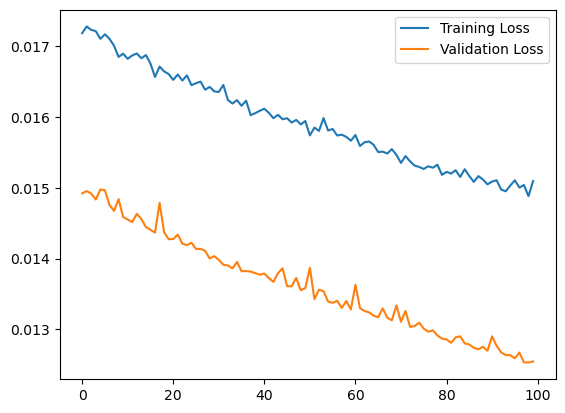

In [9]:
# Plot loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

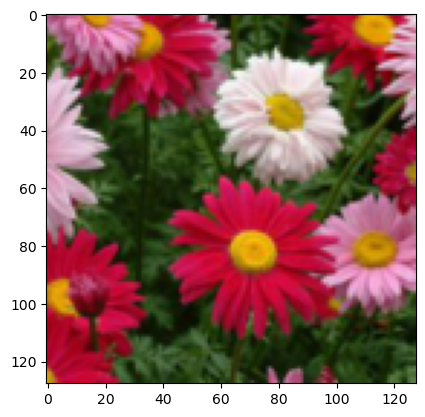

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


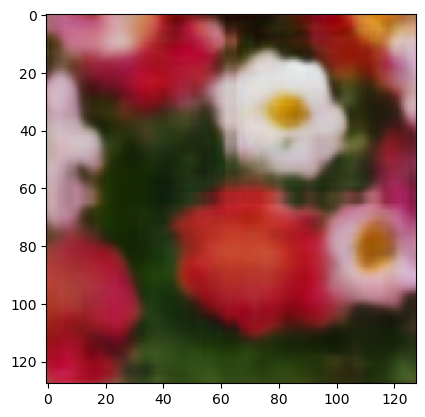

In [174]:
# Display decoder's reconstructed image
ID = 20
plt.imshow(np.transpose(val_dataset[ID][0], (1, 2, 0)))
plt.show()
out = model.forward(torch.unsqueeze(val_dataset[ID][0].cuda(), 0))
plt.imshow(np.transpose(out.cpu().detach().numpy()[0], (1, 2, 0)))
plt.show()

## 4. Main Model Implementation
CBAM and main model implementation

In [21]:
# Name of the image classifier model that will be used as part of our main model
pretrained = 'resnet101'

In [160]:
import torchvision.models as models

class SpatialGate(nn.Module):
    def __init__(self):
        super().__init__()
        kernel_size = 7
        self.conv = nn.Conv2d(
            2, 
            1, 
            kernel_size = kernel_size,
            padding = (kernel_size - 1) // 2,
            stride = 1
        )
    def forward(self, x):
        x_compress = torch.cat((torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)
        x_out = self.conv(x_compress)
        scale = nn.functional.sigmoid(x_out)
        return scale
        
class ChannelGate(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction),
            nn.ReLU(),
            nn.Linear(in_channels // reduction, in_channels)
        )
        
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)
        
        channel_attention = self.sequential(avg_pool.view(x.size(0), -1)) + self.sequential(max_pool.view(x.size(0), -1))
        scale = nn.functional.sigmoid(channel_attention).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        return scale
    
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        self.channel_gate = ChannelGate(in_channels, reduction)
        self.spatial_gate = SpatialGate()
    def forward(self, x):
        flatten_x = x.view(x.size(0), -1)
        channel_out = self.channel_gate(x)
        spatial_out = self.spatial_gate(x)        
        attention = channel_out * spatial_out

        return attention
    
class Flowers401Net(nn.Module):
    def __init__(self, model, config):
        super().__init__()
        self.transform_input = nn.AdaptiveAvgPool2d((128, 128))
        
        self.encoder = AutoEncoder(config).encoder
        self.encoder_cbam = CBAM(in_channels = config.encoder_config.features[-1])
        
         # Freeze encoder's weights
        for param in self.encoder.parameters():
            param.requires_grad = False
            
        pretrained_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        
        # Freeze resnet's weights
        for param in pretrained_model.parameters():
            param.requires_grad = False
        
        
        # Segments out only the backbone layers as list, unpacks, and load into nn.Sequential
        backbone_layers = list(pretrained_model.children())[:-1]
        self.backbone = nn.Sequential(*backbone_layers)
        self.backbone_cbam = CBAM(in_channels = 512)
        
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(8704, 1000),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 102),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.transform_input(x)
        encoder_out = self.encoder(x)
        encoder_attention = self.encoder_cbam(encoder_out)
        encoder_out = encoder_out * encoder_attention
        
        backbone_out = self.backbone(x)
        backbone_attention = self.backbone_cbam(backbone_out)
        backbone_out = backbone_out * backbone_attention
        
        flatten = torch.cat((self.flatten(encoder_out), self.flatten(backbone_out)), 1)
        
        out = self.classifier(flatten)
        
#         encoder_cat = torch.cat((encoder_out, backbone_out), 1)
        return out

In [161]:
# Create main model with encoder trained in the previous section
flower_model = Flowers401Net(copy.deepcopy(model), config).cuda()
flower_model

Using cache found in C:\Users\iraha/.cache\torch\hub\pytorch_vision_v0.10.0


Flowers401Net(
  (transform_input): AdaptiveAvgPool2d(output_size=(128, 128))
  (encoder): Encoder(
    (sequential): Sequential(
      (0): ResidualBlock(
        (main_block): Conv2dBlock(
          (sequential): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ActivationFunction(
              (activation_func): ReLU(inplace=True)
            )
            (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (shortcut_block): Conv2dBlock(
          (sequential): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (acti

### Load Flowers-102 Dataset

In [55]:
# Download dataset
train_data = datasets.Flowers102(root='', split='train', download=True)

In [156]:
from torch.utils.data import Dataset
import scipy.io
from PIL import Image

# Define custom dataset class for importing and handeling flowers-102 dataset
class Flowers102Dataset(Dataset):
    def __init__(self, root_dir, split):
        super().__init__()
        
        # Load labels and setid for each split
        labels = scipy.io.loadmat(os.path.join(root_dir, 'imagelabels.mat'))
        setid = scipy.io.loadmat(os.path.join(root_dir, 'setid.mat'))
        
        image_names = list(os.listdir(os.path.join(root_dir, 'jpg')))
        
        # Translate split name to the ones used in the .mat files
        match split:
            case 'train':
                split_id = 'trnid'
            case 'val':
                split_id = 'valid'
            case 'test':
                split_id = 'tstid'
        
        # Create list of image file path and label pairs
        set_data = [
            (os.path.join(root_dir, 'jpg', image_names[idx-1]), labels['labels'][0][idx-1] - 1)
            for idx in setid[split_id][0]
        ]
        
        # Load images into list as tensors
        self.images = []
        self.labels = []
        transform_input = nn.AdaptiveAvgPool2d((dimension, dimension))
        for image_path, class_idx in tqdm(set_data, desc=f'Importing {split} split'):
            image = Image.open(image_path)
            np_image = np.transpose(np.array(image), (2, 0, 1))
            if np.any(np_image > 1):
                np_image = np_image / 255.0
            self.images.append(transform_input(torch.tensor(np_image)))
            self.labels.append(class_idx)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

In [157]:
# We use test for training split as they contain more images
train_dataset = Flowers102Dataset('flowers-102', 'test')
val_dataset = Flowers102Dataset('flowers-102', 'val')

Importing val split: 100%|█████████████████████████████████████████████████████████| 1020/1020 [00:10<00:00, 98.70it/s]


In [158]:
train_dataset[50]

(tensor([[[0.1740, 0.1477, 0.1125,  ..., 0.1077, 0.0868, 0.0696],
          [0.2358, 0.2540, 0.2357,  ..., 0.0956, 0.1182, 0.0959],
          [0.1371, 0.1647, 0.1557,  ..., 0.0895, 0.1187, 0.0930],
          ...,
          [0.2127, 0.1872, 0.1830,  ..., 0.3754, 0.4339, 0.4766],
          [0.1861, 0.1837, 0.1925,  ..., 0.5128, 0.5285, 0.5431],
          [0.1915, 0.1999, 0.2094,  ..., 0.5192, 0.5267, 0.5317]],
 
         [[0.2015, 0.1752, 0.1400,  ..., 0.1384, 0.1161, 0.0971],
          [0.2632, 0.2814, 0.2631,  ..., 0.1218, 0.1481, 0.1234],
          [0.1645, 0.1922, 0.1831,  ..., 0.1144, 0.1464, 0.1204],
          ...,
          [0.1925, 0.1669, 0.1627,  ..., 0.3037, 0.3382, 0.3609],
          [0.1665, 0.1641, 0.1729,  ..., 0.4064, 0.3950, 0.4046],
          [0.1719, 0.1803, 0.1898,  ..., 0.4115, 0.3942, 0.4016]],
 
         [[0.1309, 0.1046, 0.0694,  ..., 0.0553, 0.0400, 0.0265],
          [0.1926, 0.2108, 0.1925,  ..., 0.0591, 0.0701, 0.0528],
          [0.0940, 0.1216, 0.1125,  ...,

### Train Main Model

In [163]:
# Define parameters
learning_rate = 0.001
epochs = 100
batch_size = 16
NUM_CLASSES = 102

# Define loss criterion
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Store epoch losses for each config and fold
train_losses = []
val_losses = []

best_weights = None
best_loss = 10000000

optimizer = optim.Adam(flower_model.parameters(), lr=learning_rate, weight_decay=0.0001)

pbar = tqdm(total=epochs, desc='Training')
for epoch in range(epochs):
    flower_model.train()
    train_loss = 0.0
    for data in train_dataloader:
        inputs, labels = data
        inputs = inputs.type(dtype)
        labels = labels.type(torch.LongTensor).cuda()
        
        optimizer.zero_grad()
        outputs = flower_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validate model
    flower_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for data in val_dataloader:
            inputs, labels = data
            inputs = inputs.type(dtype)
            labels = labels.type(torch.LongTensor).cuda()
            
            outputs = flower_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
    train_losses.append(train_loss / len(train_dataloader))
    val_losses.append(val_loss / len(val_dataloader))
    
    # Save model every epochs
    if (epoch+1)%10 == 0:
        torch.save(model.state_dict(), f'flowers_401_{str(epoch+1)}.npz')
    
    # Keep track of best weights
    if val_loss / len(val_dataloader) < best_loss:
        best_loss = val_loss / len(val_dataloader)
        best_weights = model.state_dict()

    # Update fold progress bar
    pbar.set_postfix({
        'Train Loss': train_loss / len(train_dataloader), 
        'Val Loss': val_loss / len(val_dataloader), 
        'Best Val': best_loss
    })
    pbar.update(1)
    
torch.save(best_weights, f'flowers_401_best_loss.npz')

Training: 100%|████████████████████████| 100/100 [27:09<00:00, 16.35s/it, Train Loss=3.8, Val Loss=3.81, Best Val=3.81]

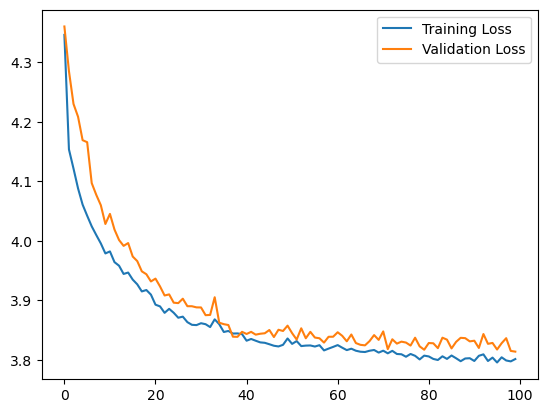

In [164]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

## 5. Testing Main Model

In [165]:
# Load test dataset
# test_dataset = Flowers102Dataset('flowers-102', 'train')
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [183]:
flower_model.eval()
num_correct = 0
num_label = 0
for images, labels in tqdm(test_dataloader):
    images = images.type(dtype)
    labels = labels.type(torch.LongTensor).cuda()
    
    outputs = flower_model.forward(images)
    output_class_idx = torch.argmax(outputs, dim=1)
    num_correct += torch.sum(output_class_idx == labels).item()
    num_label += images.size()[0]
accuracy = num_correct / num_label


100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:02<00:00, 29.93it/s]


In [184]:
print(accuracy)

0.40784313725490196


1 tensor([1], device='cuda:0')


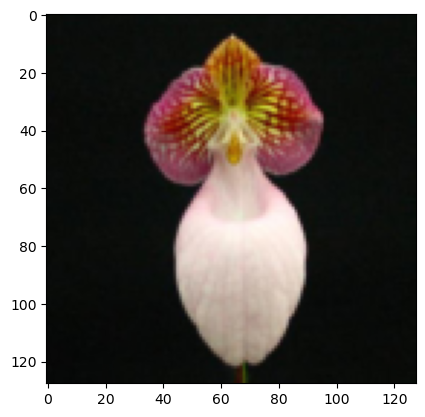

In [181]:
ID = 12
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))

0 tensor([0], device='cuda:0')


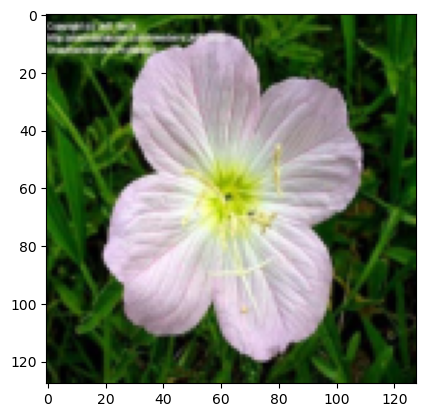

In [170]:
ID = 1
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))

1 tensor([1], device='cuda:0')


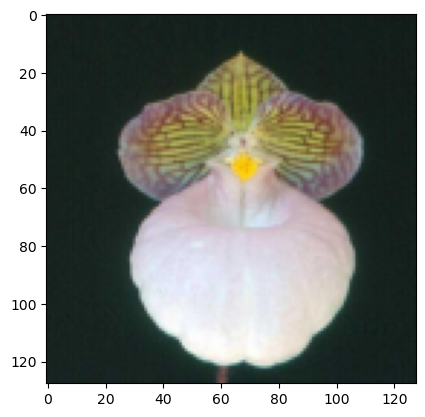

In [175]:
ID = 17
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))

18 tensor([0], device='cuda:0')


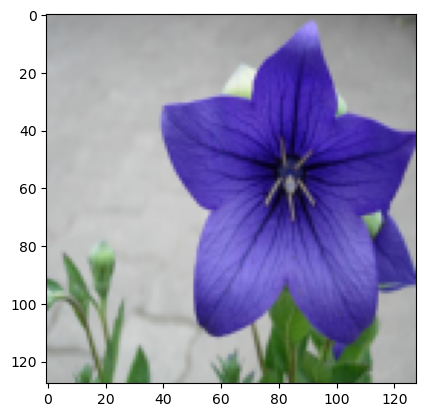

In [172]:
ID = 195
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))

29 tensor([29], device='cuda:0')


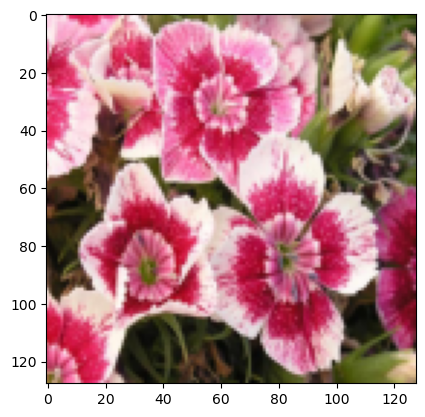

In [173]:
ID = 295
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))

80 tensor([72], device='cuda:0')


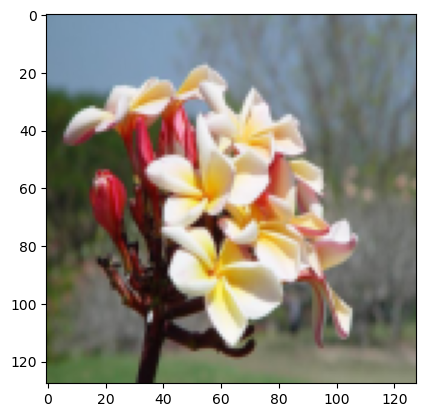

In [182]:
ID = 800
plt.imshow(np.transpose(test_dataset[ID][0], (1, 2, 0)))
outputs = flower_model.forward(torch.unsqueeze(torch.tensor(np.array(test_dataset[ID][0])).type(dtype), 0))
print(test_dataset[ID][1], torch.argmax(outputs, dim=1))